In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 91.1 MB/s eta 0:00:00


In [ ]:
import zipfile
import os

# Extract the ZIP file
zip_path = "/content/p_folder.zip"
extract_path = "/content"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extracted contents
folder_path = "/content/p_folder"
print("✅ Folder extracted successfully!")
print("📂 Contents:", os.listdir(folder_path))


✅ Folder extracted successfully!
📂 Contents: ['Modis', 'Landsat']


In [ ]:
import os
import re

# Define paths
modis_folder = "/content/p_folder/Modis"
landsat_folder = "/content/p_folder/Landsat"

# Function to extract date from filename
def extract_date(filename):
    match = re.search(r"(\d{6}|\d{8})", filename)  # Looks for 6 or 8 digit date
    return match.group(1) if match else None

# Get sorted list of MODIS and LANDSAT files based on extracted dates
modis_images = sorted([f for f in os.listdir(modis_folder) if f.endswith(".tif")], key=extract_date)
landsat_images = sorted([f for f in os.listdir(landsat_folder) if f.endswith(".tif")], key=extract_date)

# Ensure lengths match
assert len(modis_images) == len(landsat_images), "Mismatch in MODIS and LANDSAT image counts!"

# Pair images correctly
paired_images = [(os.path.join(modis_folder, m), os.path.join(landsat_folder, l))
                 for m, l in zip(modis_images, landsat_images)]

# Print matched pairs
for modis, landsat in paired_images:
    print(f"✅ MODIS: {modis}  <-->  LANDSAT: {landsat}")


✅ MODIS: /content/p_folder/Modis/Modis_020419.tif  <-->  LANDSAT: /content/p_folder/Landsat/Landsat_020419.tif
✅ MODIS: /content/p_folder/Modis/Modis_061222.tif  <-->  LANDSAT: /content/p_folder/Landsat/Landsat061222.tif
✅ MODIS: /content/p_folder/Modis/Modis_070421.tif  <-->  LANDSAT: /content/p_folder/Landsat/Landsat_070421.tif
✅ MODIS: /content/p_folder/Modis/Modis_120417.tif  <-->  LANDSAT: /content/p_folder/Landsat/Landsat_120417.tif
✅ MODIS: /content/p_folder/Modis/Modis_121119.tif  <-->  LANDSAT: /content/p_folder/Landsat/Landsat_121119.tif
✅ MODIS: /content/p_folder/Modis/Modis_130423.tif  <-->  LANDSAT: /content/p_folder/Landsat/Landsat_130423.tif
✅ MODIS: /content/p_folder/Modis/Modis_150418.tif  <-->  LANDSAT: /content/p_folder/Landsat/Landsat_150418.tif
✅ MODIS: /content/p_folder/Modis/Modis_191221.tif  <-->  LANDSAT: /content/p_folder/Landsat/Landsat191221.tif
✅ MODIS: /content/p_folder/Modis/Modis_220520.tif  <-->  LANDSAT: /content/p_folder/Landsat/Landsat_220520.tif
✅ M

In [ ]:
import os
import re
import rasterio
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define folders
modis_folder = "/content/p_folder/Modis"
landsat_folder = "/content/p_folder/Landsat"

# Function to extract date from filename
def extract_date(filename):
    match = re.search(r"(\d{6}|\d{8})", filename)  # Looks for 6 or 8 digit date
    return match.group(1) if match else filename  # If no match, return filename

# Get sorted list of MODIS and LANDSAT images
modis_images = sorted([os.path.join(modis_folder, f) for f in os.listdir(modis_folder) if f.endswith(".tif")], key=lambda x: extract_date(os.path.basename(x)))
landsat_images = sorted([os.path.join(landsat_folder, f) for f in os.listdir(landsat_folder) if f.endswith(".tif")], key=lambda x: extract_date(os.path.basename(x)))

print(f"✅ Found {len(modis_images)} MODIS and {len(landsat_images)} LANDSAT images.")

# Load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    with rasterio.open(image_path) as img:
        img_data = img.read(1)  # Read first band
        img_data = np.nan_to_num(img_data)  # Handle NaNs
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data) + 1e-8)  # Normalize
        img_data = np.expand_dims(img_data, axis=-1)  # Add channel dimension
        img_data = tf.image.resize(img_data, target_size).numpy()  # Correct resizing
    return img_data

# Load all images
X = np.array([load_and_preprocess_image(img) for img in modis_images])
Y = np.array([load_and_preprocess_image(img) for img in landsat_images])

# Split into train (12) and test (1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/13, random_state=42, shuffle=False)

print(f"✅ Training: {X_train.shape[0]} pairs, Testing: {X_test.shape[0]} pairs")


✅ Found 13 MODIS and 13 LANDSAT images.
✅ Training: 12 pairs, Testing: 1 pairs


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model

# Build Autoencoder
def build_autoencoder():
    input_layer = Input(shape=(128, 128, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Initialize model
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,569 (146.75 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = autoencoder.fit(X_train, Y_train,
                          epochs=50, batch_size=8,
                          validation_split=0.2,
                          callbacks=[early_stopping])

print("✅ Model training completed!")

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step - loss: 0.2687 - val_loss: 0.2260
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.2248 - val_loss: 0.1939
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - loss: 0.1927 - val_loss: 0.1621
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - loss: 0.1609 - val_loss: 0.1332
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 632ms/step - loss: 0.1324 - val_loss: 0.1148
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.1143 - val_loss: 0.1022
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step - loss: 0.1017 - val_loss: 0.0859
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - loss: 0.0851 - val_loss: 0.0671
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - loss: 0.0664 - val_loss: 0.0461
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0454 - val_loss: 0.0279
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - loss: 0.0274 - val_loss: 0.0158
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.0155 - val_loss:

In [ ]:
autoencoder.save("/content/modis_to_landsat_model.h5")
print("✅ Model saved!")

✅ Model saved!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
✅ Predicted Landsat image saved at: /content/predicted_landsat.tif


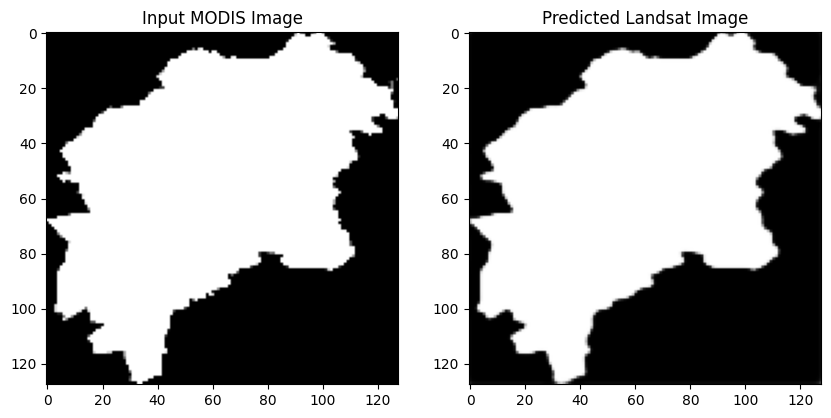

In [ ]:
import matplotlib.pyplot as plt

# Pick the test image
test_modis = np.expand_dims(X_test[0], axis=0)  # Add batch dimension
predicted_landsat = autoencoder.predict(test_modis)[0]

# Save the predicted Landsat image
output_path = "/content/predicted_landsat.tif"

with rasterio.open(modis_images[0]) as src:
    meta = src.meta.copy()
    meta.update(dtype=rasterio.float32, count=1)

    with rasterio.open(output_path, "w", **meta) as dst:
        dst.write(predicted_landsat[:, :, 0].astype(np.float32), 1)

print(f"✅ Predicted Landsat image saved at: {output_path}")

# Display the input and output
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_test[0, :, :, 0], cmap="gray")
plt.title("Input MODIS Image")

plt.subplot(1, 2, 2)
plt.imshow(predicted_landsat[:, :, 0], cmap="gray")
plt.title("Predicted Landsat Image")

plt.show()


In [ ]:
# Get the test image filenames
test_modis_image = modis_images[-1]  # Last MODIS image (used for testing)
test_landsat_image = landsat_images[-1]  # Last LANDSAT image (expected output)

print(f"🧪 Test MODIS Image: {test_modis_image}")
print(f"🎯 Expected LANDSAT Image: {test_landsat_image}")


🧪 Test MODIS Image: /content/p_folder/Modis/Modis_301120.tif
🎯 Expected LANDSAT Image: /content/p_folder/Landsat/Landsat_301120.tif


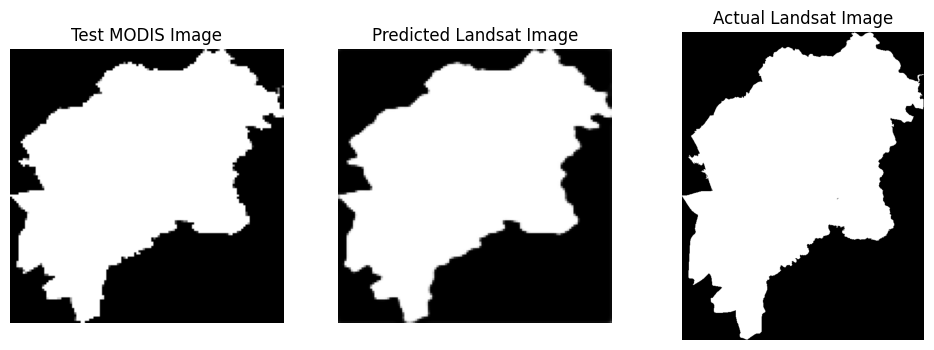

In [ ]:
import matplotlib.pyplot as plt

# Get test image paths
test_modis_path = modis_images[-1]  # Last MODIS image (used for testing)
test_landsat_path = landsat_images[-1]  # Last LANDSAT image (actual ground truth)

# Read actual Landsat image
with rasterio.open(test_landsat_path) as landsat:
    actual_landsat = landsat.read(1)  # Read first band
    actual_landsat = np.nan_to_num(actual_landsat)  # Handle NaNs
    actual_landsat = (actual_landsat - np.min(actual_landsat)) / (np.max(actual_landsat) - np.min(actual_landsat) + 1e-8)  # Normalize

# Reshape predicted Landsat image (remove extra dimension)
predicted_landsat = predicted_landsat[:, :, 0]

# Plot the images
plt.figure(figsize=(12, 4))

# MODIS Test Image
plt.subplot(1, 3, 1)
plt.imshow(X_test[0, :, :, 0], cmap='gray')
plt.title("Test MODIS Image")
plt.axis("off")

# Predicted Landsat Image
plt.subplot(1, 3, 2)
plt.imshow(predicted_landsat, cmap='gray')
plt.title("Predicted Landsat Image")
plt.axis("off")

# Actual Landsat Image
plt.subplot(1, 3, 3)
plt.imshow(actual_landsat, cmap='gray')
plt.title("Actual Landsat Image")
plt.axis("off")

plt.show()


In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2

# Ensure images are in the same shape
predicted_landsat_resized = cv2.resize(predicted_landsat, (actual_landsat.shape[1], actual_landsat.shape[0]))

# Mean Squared Error (MSE)
def mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

# Compute MSE
mse_value = mse(actual_landsat, predicted_landsat_resized)

# Compute SSIM
ssim_value = ssim(actual_landsat, predicted_landsat_resized, data_range=actual_landsat.max() - actual_landsat.min())

# Compute PSNR
psnr_value = cv2.PSNR(actual_landsat, predicted_landsat_resized)

# Print results
print(f"✅ Mean Squared Error (MSE): {mse_value:.4f}")
print(f"✅ Structural Similarity Index (SSIM): {ssim_value:.4f}")
print(f"✅ Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.2f} dB")


✅ Mean Squared Error (MSE): 0.0058
✅ Structural Similarity Index (SSIM): 0.9209
✅ Peak Signal-to-Noise Ratio (PSNR): 70.52 dB


In [ ]:
def load_and_preprocess_image_with_stats(image_path, target_size=(128, 128)):
    with rasterio.open(image_path) as img:
        img_data = img.read(1)
        img_data = np.nan_to_num(img_data)

        original_min = np.min(img_data)
        original_max = np.max(img_data)

        # Normalize
        norm_img = (img_data - original_min) / (original_max - original_min + 1e-8)
        norm_img = np.expand_dims(norm_img, axis=-1)
        norm_img = np.resize(norm_img, target_size + (1,))

    return norm_img, original_min, original_max


In [ ]:
test_landsat_path = sorted([os.path.join(landsat_folder, f) for f in os.listdir(landsat_folder) if f.endswith(".tif")])[1]
test_image_norm, test_min, test_max = load_and_preprocess_image_with_stats(test_landsat_path)



In [ ]:
predicted_dn = predicted_landsat * (test_max - test_min) + test_min


In [ ]:
import numpy as np
import rasterio

# === Assumed constants (from Landsat 8 Band 10, adjust if needed) ===
M_L = 0.0003342     # Radiance Multiplier (example)
A_L = 0.1           # Radiance Additive Term
K1 = 774.89         # Thermal constant K1
K2 = 1321.08        # Thermal constant K2

# === Temperature Calculation Function ===
def calculate_temperature_from_dn(dn_array):
    # Convert DN to TOA Radiance
    radiance = M_L * dn_array + A_L
    radiance = np.maximum(radiance, 1e-8)  # Avoid log(0)

    # Convert Radiance to Temperature in Kelvin
    temp_k = K2 / (np.log((K1 / radiance) + 1))

    # Convert to Celsius
    temp_c = temp_k - 273.15
    return temp_c

# === Load Actual and Predicted Images ===
actual_landsat_path = "/content/p_folder/Landsat/Landsat_020419.tif"
predicted_landsat_path = "/content/predicted_landsat.tif"

# Read Actual Landsat
with rasterio.open(actual_landsat_path) as actual_src:
    actual_dn = actual_src.read(1).astype(float)

# Read Predicted Landsat
with rasterio.open(predicted_landsat_path) as pred_src:
    predicted_dn = pred_src.read(1).astype(float)

# === Calculate Temperatures ===
actual_temp = calculate_temperature_from_dn(actual_dn)
predicted_temp = calculate_temperature_from_dn(predicted_dn)

# === Compute Mean Absolute Error ===
mae_temp = np.mean(np.abs(actual_temp - predicted_temp))

# === Output Results ===
print(f"✅ Actual Landsat Mean Temperature: {np.mean(actual_temp):.2f}°C")
print(f"✅ Predicted Landsat Mean Temperature: {np.mean(predicted_temp):.2f}°C")
print(f"✅ Mean Absolute Error (MAE): {mae_temp:.2f}°C")


✅ Actual Landsat Mean Temperature: -167.83°C
✅ Predicted Landsat Mean Temperature: -125.60°C
✅ Mean Absolute Error (MAE): 44.20°C
